In [1]:
#載入套件
import re #cleaning the text 
import pandas as pd 
import numpy as np 
import string
import nltk
import warnings

In [2]:
#載入資料集
train  = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train.head()

,class,tweet
0,1,"[9-1-13] 2:50 pm ""son of a bitch ate my mac n ..."
1,1,RT @BryceSerna: Don't be a pussy grab the boot...
2,2,RT @ClicquotSuave: bunch of rappers boutta flo...
3,2,@michigannews13 wow. Thats great language comi...
4,1,"and this is why I'm single, I don't fuck with ..."


In [3]:
#combine train and test set
combi = pd.concat([train, test], axis=0, ignore_index=True)
combi

,class,tweet,id
0,1.0,"[9-1-13] 2:50 pm ""son of a bitch ate my mac n ...",NaN
1,1.0,RT @BryceSerna: Don't be a pussy grab the boot...,NaN
2,2.0,RT @ClicquotSuave: bunch of rappers boutta flo...,NaN
3,2.0,@michigannews13 wow. Thats great language comi...,NaN
4,1.0,"and this is why I'm single, I don't fuck with ...",NaN
...,...,...,...
24778,NaN,you're all niggers,9909.0
24779,NaN,you's a muthaf***in lie &#8220;@LifeAsKing: @2...,9910.0
24780,NaN,young buck wanna eat!!.. dat nigguh like I ain...,9911.0
24781,NaN,youu got wild bitches tellin you lies,9912.0


In [ ]:
'''
對於文字型資料處理不太熟悉，所以上網搜尋參考資料：
https://github.com/sachink382/Twitter-Sentiment-Analysis---Analytics-Vidhya
'''

In [4]:
## importing regular expression library ## clean tweet text by removing links, special characters etc
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
        
    return input_txt

# remove twitter handles (@user)
combi['tweet'] = np.vectorize(remove_pattern)(combi['tweet'], "@[\w]*")

# remove special characters, numbers, punctuations
combi['tweet'] = combi['tweet'].str.replace("[^a-zA-Z#]", " ", regex=True)
       
#Removing Short Words       
combi['tweet'] = combi['tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))       

tokenized_tweet = combi['tweet'].apply(lambda x: x.split())
tokenized_tweet

0                              [bitch, cheese, http, oJYZ]
1        [pussy, grab, booty, Love, booty, Appreciate, ...
2        [bunch, rappers, boutta, flood, internets, tra...
3        [Thats, great, language, coming, from, coach, ...
4        [this, single, fuck, with, bitches, there, att...
                               ...                        
24778                                            [niggers]
24779    [muthaf, right, trash, mine, Bible, scriptures...
24780    [young, buck, wanna, nigguh, like, aint, fucki...
24781                  [youu, wild, bitches, tellin, lies]
24782    [Ruffled, Ntac, Eileen, Dahlia, Beautiful, col...
Name: tweet, Length: 24783, dtype: object

In [5]:
from nltk.stem.porter import *
stemmer = PorterStemmer()

tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x]) # stemming

#Now let’s stitch these tokens
for i in range(len(tokenized_tweet)):
    tokenized_tweet[i] = ' '.join(tokenized_tweet[i])

combi['tweet'] = tokenized_tweet

#Bag-of-Words Features

from sklearn.feature_extraction.text import CountVectorizer
bow_vectorizer = CountVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
# bag-of-words feature matrix
bow = bow_vectorizer.fit_transform(combi['tweet'])

In [6]:
train_bow = bow[:14869,:]
test_bow = bow[14869:,:]

y_train = train['class']

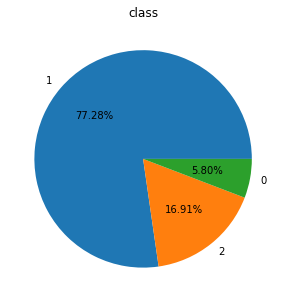

In [7]:
import matplotlib.pyplot as plt
plt.figure( figsize=(10,5) )
y_train.value_counts().plot( kind='pie', autopct='%1.2f%%' )
plt.title( 'class' )  # 圖標題
plt.ylabel( '' )
plt.show()

In [8]:
#處理資料不平衡的問題
from imblearn.over_sampling import BorderlineSMOTE
bsmote = BorderlineSMOTE()
xtrain_bow_bs, ytrain_bs = bsmote.fit_resample(train_bow, y_train)

from imblearn.under_sampling import TomekLinks
X_res, y_res = TomekLinks().fit_resample(xtrain_bow_bs, ytrain_bs)

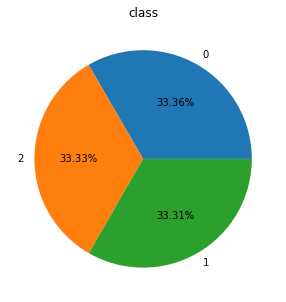

In [9]:
plt.figure( figsize=(10,5) )
y_res.value_counts().plot( kind='pie', autopct='%1.2f%%' )
plt.title( 'class' ) 
plt.ylabel( '' )
plt.show()

In [10]:
#使用XGBoost模型預測資料
from xgboost import XGBClassifier

model = XGBClassifier(n_estimators=100, learning_rate= 0.3)

model.fit(X_res, y_res)

test_pred = model.predict(test_bow)
test['class'] = test_pred

In [11]:
submission = test[['id','class']]
submission
submission.to_csv('output1.csv', index=False) # writing data to a CSV file